In [76]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import imageio

%matplotlib inline

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

IndexError: index 1 is out of bounds for axis 0 with size 1

y=27: [1] meaning its a cat


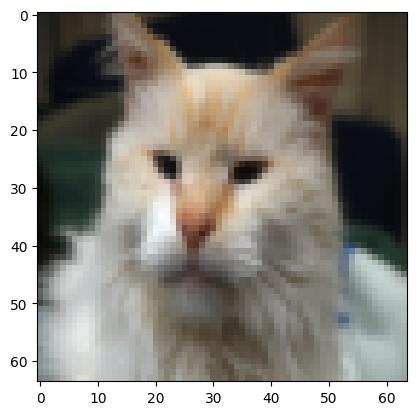

In [19]:
index = 27
plt.imshow(train_set_x_orig[index])
print(f"y={index}: {train_set_y[:, index]} meaning its a {classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}")

In [26]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [27]:
# Reshaping the image vector to one single vector 

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [28]:
train_set_x_flatten

array([[ 17, 196,  82, ..., 143,  22,   8],
       [ 31, 192,  71, ..., 155,  24,  28],
       [ 56, 190,  68, ..., 165,  23,  53],
       ...,
       [  0,  82, 138, ...,  85,   4,   0],
       [  0,  80, 141, ..., 107,   5,   0],
       [  0,  81, 142, ..., 149,   0,   0]], dtype=uint8)

In [29]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [32]:
# Preprocessing 

# **What you need to remember:**
# Common steps for pre-processing a new dataset are:

# Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
# Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
# "Standardize" the data


train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

test_set_x


array([[0.61960784, 0.45098039, 1.        , ..., 0.16078431, 0.07058824,
        0.52156863],
       [0.40784314, 0.43137255, 0.99215686, ..., 0.18431373, 0.07058824,
        0.63921569],
       [0.3254902 , 0.43529412, 0.99607843, ..., 0.32941176, 0.0627451 ,
        0.29411765],
       ...,
       [0.67843137, 0.67058824, 0.52156863, ..., 0.71764706, 0.56470588,
        0.01960784],
       [0.50196078, 0.69019608, 0.39607843, ..., 0.55294118, 0.5372549 ,
        0.08627451],
       [0.43137255, 0.72941176, 0.4745098 , ..., 0.45490196, 0.42352941,
        0.01960784]])

In [49]:
def sigmoid(z):
    s = 1/(1+ np.exp(-z))
    return s


def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    
    # To check if everything is all right
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost 

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    # A row vector
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0,i] > 0.5 else 0
    
    return Y_prediction 


def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate = 0.5, print_cost = False ):
    
    w, b= initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
        
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
        
    

# print ("sigmoid(0) = " + str(sigmoid(0)))
# print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

# dim = 10
# w, b = initialize_with_zeros(dim)
# print(w)
# print(b)

# w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
# grads, cost = propagate(w, b, X, Y)
# print ("dw = " + str(grads["dw"]))
# print ("db = " + str(grads["db"]))
# print ("cost = " + str(cost))

# params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

# print ("w = " + str(params["w"]))
# print ("b = " + str(params["b"]))
# print ("dw = " + str(grads["dw"]))
# print ("db = " + str(grads["db"]))

# print("predictions = " + str(predict(w, b, X)))

In [59]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


1.0

1.0

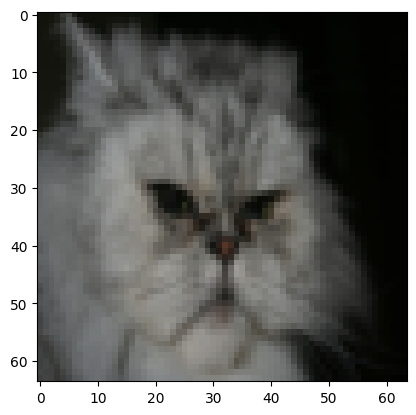

In [71]:
index = 12
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
d["Y_prediction_test"][0,index]

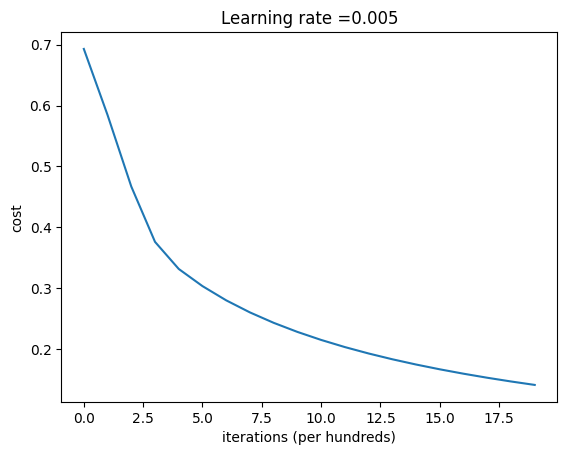

In [52]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



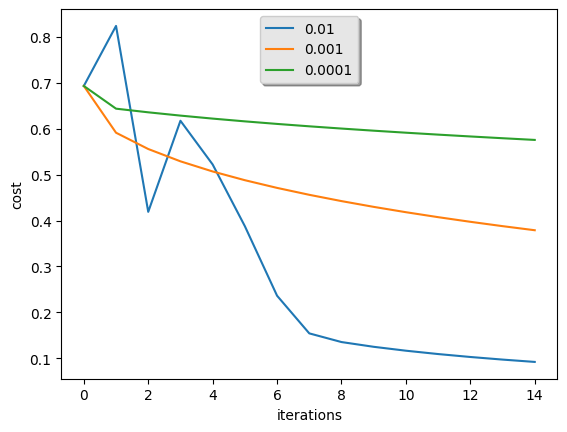

In [72]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [78]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "ca.jpeg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = my_image
image = np.array(imageio.imread(fname))
my_image = scipy.misc.imresize(image, size=(num_px, num_px)).reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)


C:\Users\mtsar\AppData\Local\Temp\ipykernel_16596\2065235596.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


AttributeError: scipy.misc is deprecated and has no attribute imresize.